In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geom
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.tree import DecisionTreeRegressor as DT
np.random.seed(10)

# Problem Statement

### We want to predict when people might have surgery

## Challenges



### Suppose the probabiltiy ($p$) of an event occurring on a given day is not a fixed value, but instead is a variable the depends on one or more risk factors.

We have a population of people aged 25-75, where probability of getting surgery increases with age according to $$\Large p = \frac {1}{1+e^{(-a-b\times \text {age})}}$$

Where $a$ is the intercept of the log-odds (e.g. baseline risk) and $b$ is the hazard associated with each unit increase of age.

In [2]:
n = 5000
df = pd.DataFrame()
df['age'] = np.random.randint(25, 76, size=n)

In [3]:
df

,age
0,34
1,61
2,40
3,25
4,74
...,...
4995,25
4996,56
4997,37
4998,27


In [4]:
a=-10.5
b=0.05
timeout = 365*3

In [5]:
prob_values = 1/(1+np.exp(-a-b*df['age']))

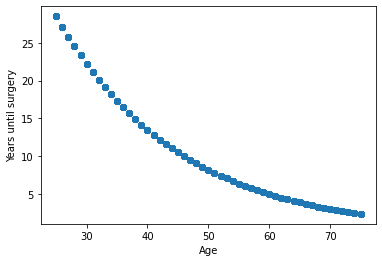

In [6]:
plt.scatter(df['age'],1/(365*prob_values))
plt.xlabel('Age')
plt.ylabel('Years until surgery');

### We would like to observe these people until they get surgery, but in some cases, that might be over 150 years.

We have a cut-off at 3 years.

In [7]:
days = geom(prob_values).rvs()
df['observation'] = np.where(days <= timeout, days, np.nan)
df

,age,observation
0,34,NaN
1,61,NaN
2,40,139.0
3,25,NaN
4,74,808.0
...,...,...
4995,25,NaN
4996,56,NaN
4997,37,NaN
4998,27,NaN


In [8]:
(df['observation'].isna()).mean()

0.66

In [9]:
days.max()/365

203.23287671232876

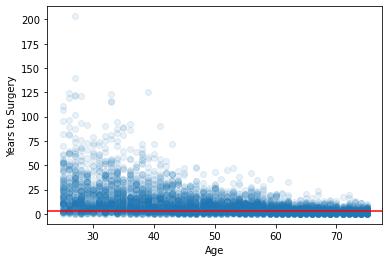

In [10]:
plt.scatter(df['age'],days/365, alpha=.1)
plt.axhline(timeout/365, color='red')
plt.xlabel('Age')
plt.ylabel('Years to Surgery');

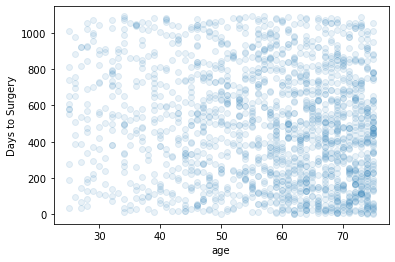

In [11]:
plt.scatter(df['age'], df['observation'], alpha = .1)
plt.xlabel('age')
plt.ylabel('Days to Surgery');

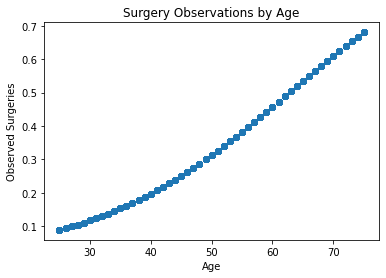

In [12]:
S = LogR().fit(df[['age']],df['observation'].isna()).predict_proba(df[['age']])[:,0]
plt.scatter(df['age'], S)
plt.xlabel('Age')
plt.ylabel('Observed Surgeries')
plt.title('Surgery Observations by Age');

$$\text {Imputed Days to Surgery} = timeout + \frac {1}{1-\left (1-S(age)\right )^{\left(\frac {1}{timeout}\right)}}$$

In [13]:
df['imputed_days'] = np.where(df['observation'].isna(), timeout + (1/(1-(1-S)**(1/timeout))), df['observation'])
df

,age,observation,imputed_days
0,34,NaN,8086.596519
1,61,NaN,2805.067070
2,40,139.0,139.000000
3,25,NaN,12888.857759
4,74,808.0,808.000000
...,...,...,...
4995,25,NaN,12888.857759
4996,56,NaN,3258.180704
4997,37,NaN,6992.432386
4998,27,NaN,11580.952244


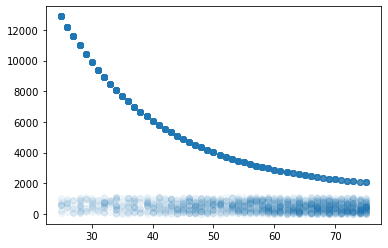

In [14]:
plt.scatter(df['age'], df['imputed_days'], alpha = .05);

In [15]:
df['probability'] = 1/DT().fit(df[['age']], df['imputed_days']).predict(df[['age']])
df

,age,observation,imputed_days,probability
0,34,NaN,8086.596519,0.000151
1,61,NaN,2805.067070,0.000612
2,40,139.0,139.000000,0.000202
3,25,NaN,12888.857759,0.000087
4,74,808.0,808.000000,0.001163
...,...,...,...,...
4995,25,NaN,12888.857759,0.000087
4996,56,NaN,3258.180704,0.000435
4997,37,NaN,6992.432386,0.000171
4998,27,NaN,11580.952244,0.000094


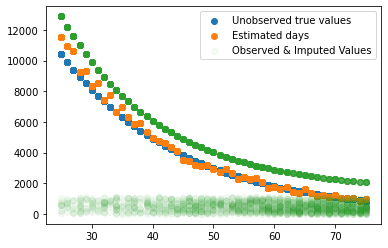

In [16]:
plt.scatter(df['age'],1/prob_values, label = 'Unobserved true values');
plt.scatter(df['age'], 1/df['probability'], label = 'Estimated days')
plt.scatter(df['age'], df['imputed_days'], alpha = .05, label = 'Observed & Imputed Values')
plt.legend()

In [17]:
log_odds = np.log(df['probability']/(1-df['probability']))
log_odds

0      -8.799974
1      -7.398841
2      -8.506814
3      -9.351551
4      -6.755243
          ...   
4995   -9.351551
4996   -7.740630
4997   -8.670898
4998   -9.268463
4999   -7.759759
Name: probability, Length: 5000, dtype: float64

In [18]:
lr = LR().fit(df[['age']], log_odds)

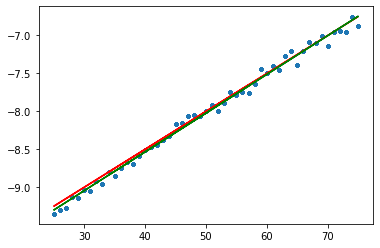

In [19]:
plt.scatter(df['age'], log_odds, s=10)
plt.plot(df['age'], df['age']*b+a, color = 'red')
plt.plot(df['age'], lr.predict(df[['age']]), color = 'green');

In [20]:
lr.intercept_, a

(-10.577082243941442, -10.5)

In [21]:
lr.coef_, b

(array([0.05107532]), 0.05)

# Results

### What is the probability that a member will have surgery in 6-18 months?

In [22]:
df['target']= df['probability'].apply(lambda p:geom(p).cdf(18*30)-geom(p).cdf(6*30))
df

,age,observation,imputed_days,probability,target
0,34,NaN,8086.596519,0.000151,0.051402
1,61,NaN,2805.067070,0.000612,0.177061
2,40,139.0,139.000000,0.000202,0.067655
3,25,NaN,12888.857759,0.000087,0.030297
4,74,808.0,808.000000,0.001163,0.277625
...,...,...,...,...,...
4995,25,NaN,12888.857759,0.000087,0.030297
4996,56,NaN,3258.180704,0.000435,0.133960
4997,37,NaN,6992.432386,0.000171,0.058050
4998,27,NaN,11580.952244,0.000094,0.032833


/home/land/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


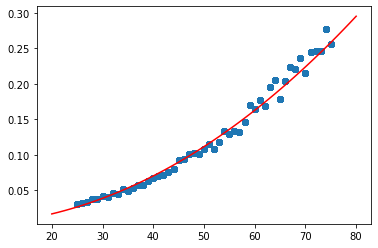

In [23]:
plt.scatter(df['age'], df['target'])
ages = np.linspace(20, 80)
plt.plot(ages, np.exp(LR().fit(np.log(df[['age']]),
                                       np.log(df['target'])
                                      )
                              .predict(np.log(ages.reshape(-1,1)))),
                            color = 'red');


# What if we want to predict outside of our observation window?

#### How many people in this population would have surgery within 3-5 years?

In [24]:
((days>(3*365))&(days<(5*365))*1).sum()

684

#### How many were *observed* to have surgery in 3-5 years?

In [25]:
((df['observation']>(3*365))&(df['observation']<(5*365))*1).sum()

0

#### How many people do we *predict* will have surgery in 3-5 years?

In [26]:
df['probability'].apply(lambda p:geom(p).cdf(5*365)-geom(p).cdf(3*365)).sum()

686.7008122031962

# Multi-variate Example

In [27]:
features = 10
df = pd.DataFrame(data = np.random.random(size = (20000, features)))
w = np.random.random(features)-.5

In [28]:
intercept = -6

The probability of getting surgery (per day) is determined by the risk factors according to:

$$\Large p = \frac {1}{1+e^{-\left (x_{0}+\vec x \cdot \vec w\right )}}$$

Where $\vec x$ is the set of risk factors for each person and $\vec w$ is the relative hazard associated with each risk factor.

We don't know what $\vec w$ is. We want to be able to discover this from the data.

In [29]:
p = 1/(1+np.exp(-intercept-df.apply(lambda x:x.dot(w),axis=1)))

## Here are the risk factors for each person:

In [30]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.340476,0.521505,0.463536,0.528105,0.194622,0.149894,0.789270,0.564662,0.697309,0.118121
1,0.992410,0.443413,0.620375,0.565303,0.020340,0.295002,0.511208,0.091903,0.039323,0.847954
2,0.514262,0.876232,0.833502,0.793124,0.832611,0.177912,0.192722,0.530803,0.356164,0.084638
3,0.853063,0.394225,0.641286,0.215408,0.776013,0.594363,0.167266,0.418771,0.023993,0.067649
4,0.199297,0.776289,0.236198,0.078524,0.744517,0.892935,0.067300,0.471629,0.105958,0.570526
...,...,...,...,...,...,...,...,...,...,...
19995,0.336722,0.581557,0.185829,0.050603,0.523471,0.295077,0.372939,0.052565,0.714421,0.253697
19996,0.214654,0.656528,0.589564,0.672447,0.284410,0.080003,0.984081,0.502669,0.223300,0.347627
19997,0.811985,0.775324,0.282103,0.209058,0.508766,0.062687,0.760714,0.293419,0.823270,0.299300
19998,0.315369,0.548349,0.069296,0.720675,0.537499,0.323688,0.985746,0.839238,0.852053,0.606016


In [31]:
N = geom(p).rvs()

## We only have 180 days of data for each person

In [32]:
timeout = 180

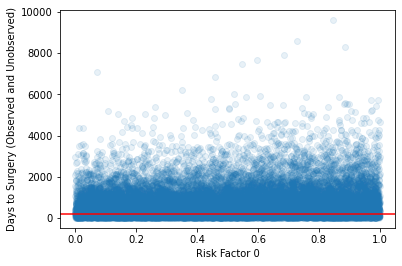

In [33]:
plt.scatter(df[0], N, alpha=.1)
plt.axhline(timeout, color='red')
plt.xlabel('Risk Factor 0')
plt.ylabel('Days to Surgery (Observed and Unobserved)');

## Any surgery that happens after 180 days is not observed, so we mark it as NaN

In [34]:
df['observation'] = np.where(N<=timeout, N, np.nan)

## About 78% of our members do not have surgery within the observation window

In [35]:
df['observation'].isna().mean()

0.77895

## Plots of the Number of days to surgery vs. the risk factors shows no discernable pattern

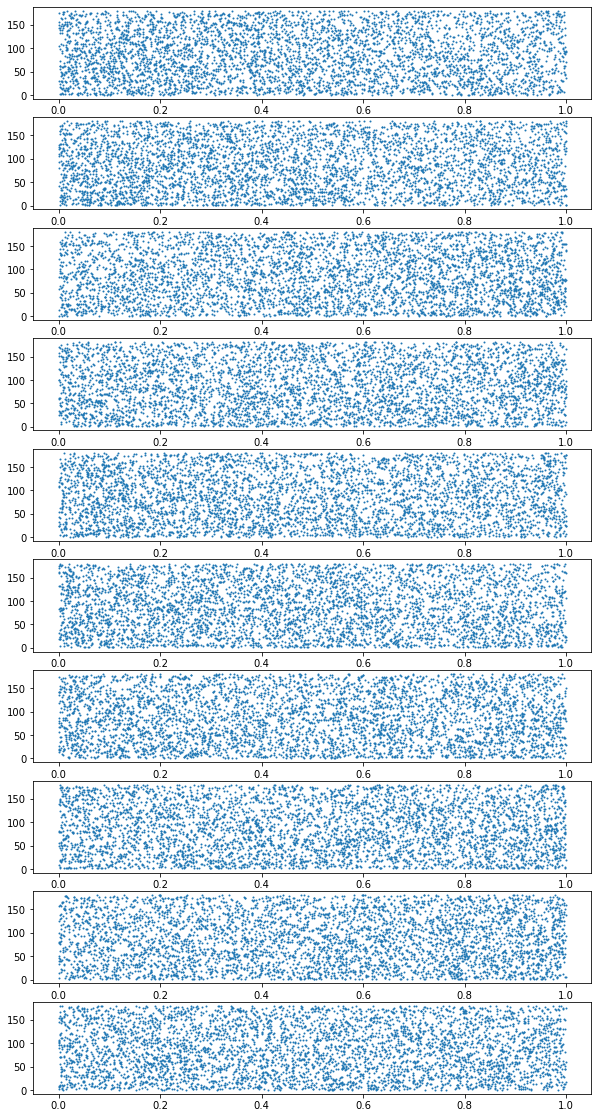

In [36]:
fig, axs = plt.subplots(features, figsize=(10,20))

for i, ax in enumerate(axs):
    ax.scatter(df[i],df['observation'], s=1)

## First, we identify the probability that a person has surgery within the observation window, based on their risk factors.

In [37]:
S = np.where(df['observation'].isna(),
                   LogR().fit(df.iloc[:,:features],df['observation'].isna())\
.predict_proba(df.iloc[:,:features])[:,0],
                   np.nan)

## Next, we create a place-holder value, an estimate of the number of days in the future when we think they might have surgery:

$$Λ = k + \frac {1}{1-\left (1-S \right )^{\frac {1}{k}}}  $$

Where $k$ is our timeout (180 days) and $S$ is the estimated probability that a surgery was observed for each member.

In [38]:
Λ = timeout + 1/(1-((1-S)**(1/timeout)))

In [39]:
df['x'] = np.where(df['observation'].isna(), Λ, df['observation'])
df

,0,1,2,3,4,5,6,7,8,9,observation,x
0,0.340476,0.521505,0.463536,0.528105,0.194622,0.149894,0.789270,0.564662,0.697309,0.118121,79.0,79.000000
1,0.992410,0.443413,0.620375,0.565303,0.020340,0.295002,0.511208,0.091903,0.039323,0.847954,NaN,984.012162
2,0.514262,0.876232,0.833502,0.793124,0.832611,0.177912,0.192722,0.530803,0.356164,0.084638,NaN,921.626829
3,0.853063,0.394225,0.641286,0.215408,0.776013,0.594363,0.167266,0.418771,0.023993,0.067649,NaN,1075.870210
4,0.199297,0.776289,0.236198,0.078524,0.744517,0.892935,0.067300,0.471629,0.105958,0.570526,NaN,1191.424697
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.336722,0.581557,0.185829,0.050603,0.523471,0.295077,0.372939,0.052565,0.714421,0.253697,106.0,106.000000
19996,0.214654,0.656528,0.589564,0.672447,0.284410,0.080003,0.984081,0.502669,0.223300,0.347627,NaN,791.304144
19997,0.811985,0.775324,0.282103,0.209058,0.508766,0.062687,0.760714,0.293419,0.823270,0.299300,NaN,1002.840732
19998,0.315369,0.548349,0.069296,0.720675,0.537499,0.323688,0.985746,0.839238,0.852053,0.606016,NaN,892.582257


## We can now use linear regression to use these *anticipated* observations to estimate the averge time to surgery ($\hat x$) for any combination of risk factors.

In [40]:
df['x_pred'] = LR().fit(df.iloc[:,:features],
                        df['x']).predict(df.iloc[:,:features])

In [41]:
df['log_odds'] = LR().fit(df.iloc[:,:features],
np.log((1/df['x_pred'])/(1-(1/df['x_pred'])))).predict(df.iloc[:,:features])
df

,0,1,2,3,4,5,6,7,8,9,observation,x,x_pred,log_odds
0,0.340476,0.521505,0.463536,0.528105,0.194622,0.149894,0.789270,0.564662,0.697309,0.118121,79.0,79.000000,551.481558,-6.311611
1,0.992410,0.443413,0.620375,0.565303,0.020340,0.295002,0.511208,0.091903,0.039323,0.847954,NaN,984.012162,821.414139,-6.691897
2,0.514262,0.876232,0.833502,0.793124,0.832611,0.177912,0.192722,0.530803,0.356164,0.084638,NaN,921.626829,766.347498,-6.611055
3,0.853063,0.394225,0.641286,0.215408,0.776013,0.594363,0.167266,0.418771,0.023993,0.067649,NaN,1075.870210,903.377798,-6.805860
4,0.199297,0.776289,0.236198,0.078524,0.744517,0.892935,0.067300,0.471629,0.105958,0.570526,NaN,1191.424697,990.682032,-6.929348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.336722,0.581557,0.185829,0.050603,0.523471,0.295077,0.372939,0.052565,0.714421,0.253697,106.0,106.000000,721.298025,-6.550967
19996,0.214654,0.656528,0.589564,0.672447,0.284410,0.080003,0.984081,0.502669,0.223300,0.347627,NaN,791.304144,617.986620,-6.404857
19997,0.811985,0.775324,0.282103,0.209058,0.508766,0.062687,0.760714,0.293419,0.823270,0.299300,NaN,1002.840732,839.787100,-6.716863
19998,0.315369,0.548349,0.069296,0.720675,0.537499,0.323688,0.985746,0.839238,0.852053,0.606016,NaN,892.582257,733.691233,-6.567863


## Let's see how our predicted probability, (derived from some really crummy data) corresponds to the ideal probability.

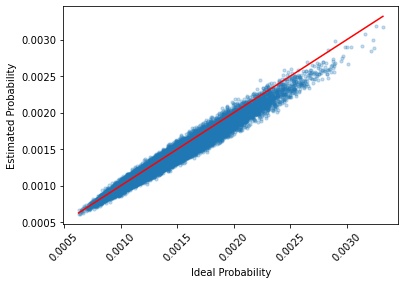

In [42]:
plt.scatter(p, 1/(1+1/np.exp(df['log_odds'])), alpha=.25,s=10)
plt.xticks(rotation=45)

plt.plot([p.min(), p.max()],[p.min(), p.max()],  color = 'red')

plt.xlabel('Ideal Probability')
plt.ylabel('Estimated Probability');

## Evaluation of Risk Factors

We can evaluate how much each feature contributes to a person's risk from the observed data by fitting an equation between the features and the log odds.

In [43]:
lr = LR().fit(df.iloc[:,:features], df['log_odds'])

We can compare these empirical values to the values used to create the dataset:

In [44]:
lr.intercept_, intercept

(-6.0966196359241485, -6)

In [45]:
lr.coef_

array([-0.4144666 , -0.44387544,  0.29924616,  0.01883929, -0.2307285 ,
       -0.34195785, -0.0690224 ,  0.03951179,  0.20772759, -0.06412428])

In [46]:
w

array([-0.45993984, -0.47297884,  0.24082588,  0.06555802, -0.23144447,
       -0.3320387 , -0.14818597,  0.12493613,  0.16080506, -0.0716675 ])

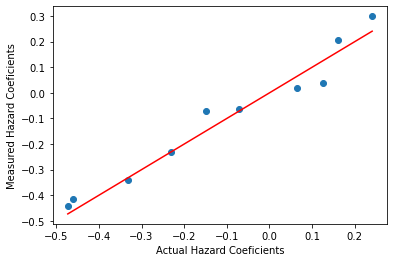

In [47]:
plt.scatter(w, lr.coef_)
plt.plot([w.min(), w.max()], [w.min(),w.max()], color = 'red')
plt.xlabel('Actual Hazard Coeficients')
plt.ylabel('Measured Hazard Coeficients');

## Conclusion:

We now know how much each risk factors contributes to the probability that a person will get surgery in a given timeframe.